In [3]:
from itertools import repeat

from common.data.data_point_transforms import EEGDatasetSampleContainer

"""
NOTE:
- Info object definisce channels e sfreq.
- Raw : EEG data (da fs) + INFO
"""
import mne

import torch
import numpy as np
from common.data.eeg.utils import EEGNMERawTransform, EEGNMEAddAnnotationTransform, find_segments
from common.data.transform import Compose

In [4]:
path = "../../../resources/AMIGOS/pre_processed_py/Data_Preprocessed_P01.npz"
d = np.load(path, allow_pickle=True)

eeg = d["joined_data"][1]
eeg = eeg[:, :14]

In [15]:
from common.data.eeg.eeg import EEG

ch_names = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
ch_types = ["eeg"] * len(ch_names)

og_x = EEGDatasetSampleContainer(entry_id="ONE", eeg=EEG(data=eeg.T, file_path=None, fs=128, interval=None))

raw_transform = EEGNMERawTransform(channel_names=ch_names, channel_types=ch_types)
annotation_transform = EEGNMEAddAnnotationTransform()

res = raw_transform(og_x)
print(res)

res.eeg.interval = (0.1, 2)

res = annotation_transform(res)
print(res.eeg.data.annotations)
print()
res.eeg.interval = (2, 5)
res.entry_id = res.entry_id + str(1)
res = annotation_transform(res)
print(res.eeg.data.annotations)

EEGDatasetDataCollection(entry_id='ONE', eeg=EEG(data=<RawArray | 14 x 7229 (56.5 s), ~806 KiB, data loaded>, file_path=None, fs=128, interval=None), vid=None, txt=None, aud=None)
<Annotations | 1 segment: ONE (1)>

<Annotations | 2 segments: ONE (1), ONE1 (1)>


In [16]:
big_raw = mne.concatenate_raws([res.eeg.data], on_mismatch="ignore")
big_raw.save("all_recordings_raw.fif", overwrite=True, split_size="2GB")

Overwriting existing file.
Writing /home/jacopo/PycharmProjects/progetto-tesi/common/data/eeg/all_recordings_raw.fif
Overwriting existing file.
Closing /home/jacopo/PycharmProjects/progetto-tesi/common/data/eeg/all_recordings_raw.fif
[done]


[PosixPath('/home/jacopo/PycharmProjects/progetto-tesi/common/data/eeg/all_recordings_raw.fif')]

In [17]:
raw = mne.io.read_raw_fif('all_recordings_raw.fif')

Opening raw data file all_recordings_raw.fif...
Isotrak not found
    Range : 0 ... 7228 =      0.000 ...    56.469 secs
Ready.


In [18]:
r = find_segments(raw, "ONE")
r

[(0.1, 1.899999976158142, np.str_('ONE')), (2.0, 3.0, np.str_('ONE1'))]

In [19]:
from common.data.eeg.utils import get_segment_raw

r = find_segments(raw, "ONE")
print(r[0][0])
seg_raw = get_segment_raw(big_raw, r[0][0], r[0][1])

0.1


In [20]:
seg_raw

<RawArray | 14 x 244 (1.9 s), ~42 KiB, data loaded>

In [7]:
res = annotation_transform(res)
print(res.eeg.data.annotations)

<Annotations | 4 segments: segment (4)>


In [46]:
import mne
import numpy as np

import mne

# Sampling frequency in AMIGOS: 128 Hz
sfreq = 128

ch_names = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
ch_types = ["eeg"] * len(ch_names)

info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# If you have the data in shape (n_channels, n_times):
# raw = mne.io.RawArray(data, info)
info

<Info | 7 non-empty values
 bads: []
 ch_names: AF3, F7, F3, FC5, T7, P7, O1, O2, P8, T8, FC6, F4, F8, AF4
 chs: 14 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 128.0 Hz
>

In [34]:
d = np.load("../../../resources/AMIGOS/pre_processed_py/Data_Preprocessed_P01.npz", allow_pickle=True)

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fz, Cz, Pz, O1, O2
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 64.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 128.0 Hz
>

In [54]:
eeg = d["joined_data"][1]

In [55]:
eeg = d["joined_data"][1]
eeg = eeg[:, :14]


In [56]:
arr = mne.io.RawArray(eeg.T, info)

Creating RawArray with float64 data, n_channels=14, n_times=7229
    Range : 0 ... 7228 =      0.000 ...    56.469 secs
Ready.


In [60]:
events = mne.preprocessing.find_eog_events(arr, ch_name="AF3")

Using EOG channel: AF3
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel AF3 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 26 significant peaks
Number of EOG events detected: 26


In [61]:
epochs = mne.Epochs(arr, events, tmin=-0.3, tmax=0.7)

Not setting metadata
26 matching events found
Setting baseline interval to [-0.296875, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


In [62]:
epochs


<Epochs | 26 events (good & bad), -0.297 – 0.703 s (baseline -0.297 – 0 s), ~15 KiB, data not loaded,
 '998': 26>

You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Using data from preloaded Raw for 10 events and 129 original time points ...


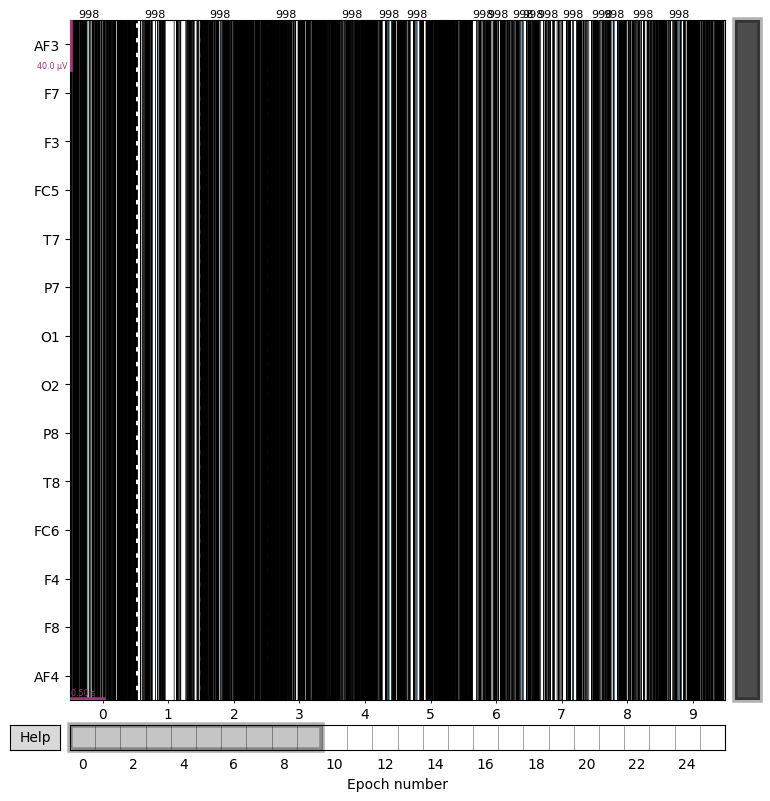

A


In [66]:
epochs.plot(n_epochs=10, events=True)
print("A")

In [28]:
events

array([], shape=(0, 3), dtype=int32)

In [22]:
simulated_epochs = mne.EpochsArray(arr, info)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (7, 2) + inhomogeneous part.

In [1]:
import mne
import numpy as np

# Create some dummy metadata
n_channels = 32
sampling_freq = 200  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 200.0 Hz
>


In [2]:
times = np.linspace(0, 1, sampling_freq, endpoint=False)
sine = np.sin(20 * np.pi * times)
cosine = np.cos(10 * np.pi * times)
data = np.array([sine, cosine])

In [3]:
data

array([[ 0.00000000e+00,  3.09016994e-01,  5.87785252e-01,
         8.09016994e-01,  9.51056516e-01,  1.00000000e+00,
         9.51056516e-01,  8.09016994e-01,  5.87785252e-01,
         3.09016994e-01,  1.22464680e-16, -3.09016994e-01,
        -5.87785252e-01, -8.09016994e-01, -9.51056516e-01,
        -1.00000000e+00, -9.51056516e-01, -8.09016994e-01,
        -5.87785252e-01, -3.09016994e-01, -2.44929360e-16,
         3.09016994e-01,  5.87785252e-01,  8.09016994e-01,
         9.51056516e-01,  1.00000000e+00,  9.51056516e-01,
         8.09016994e-01,  5.87785252e-01,  3.09016994e-01,
         3.67394040e-16, -3.09016994e-01, -5.87785252e-01,
        -8.09016994e-01, -9.51056516e-01, -1.00000000e+00,
        -9.51056516e-01, -8.09016994e-01, -5.87785252e-01,
        -3.09016994e-01, -4.89858720e-16,  3.09016994e-01,
         5.87785252e-01,  8.09016994e-01,  9.51056516e-01,
         1.00000000e+00,  9.51056516e-01,  8.09016994e-01,
         5.87785252e-01,  3.09016994e-01,  6.12323400e-1

Creating RawArray with float64 data, n_channels=2, n_times=200
    Range : 0 ... 199 =      0.000 ...     0.995 secs
Ready.
Using matplotlib as 2D backend.


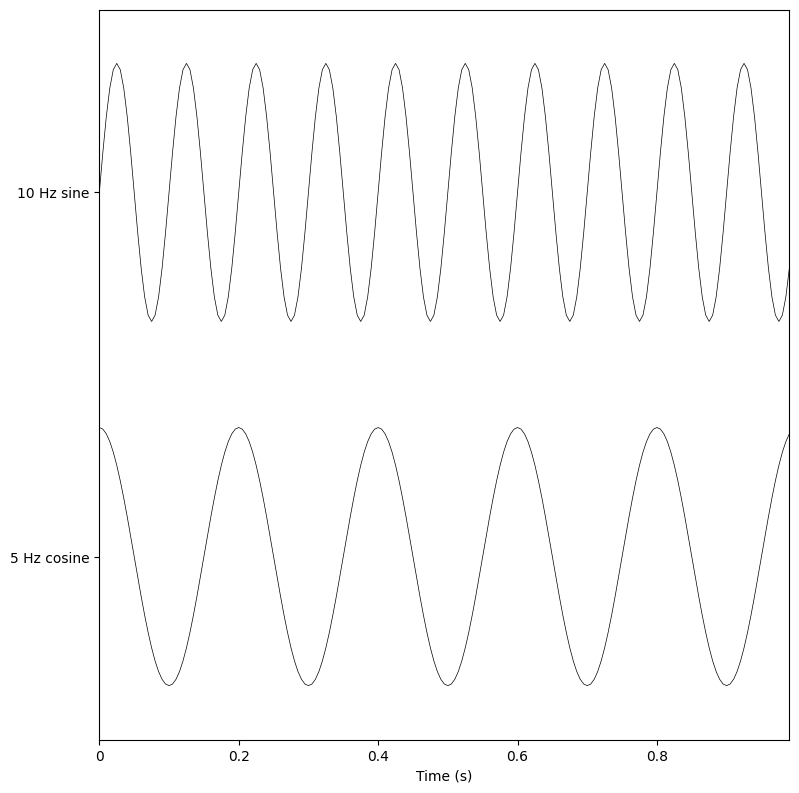

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.


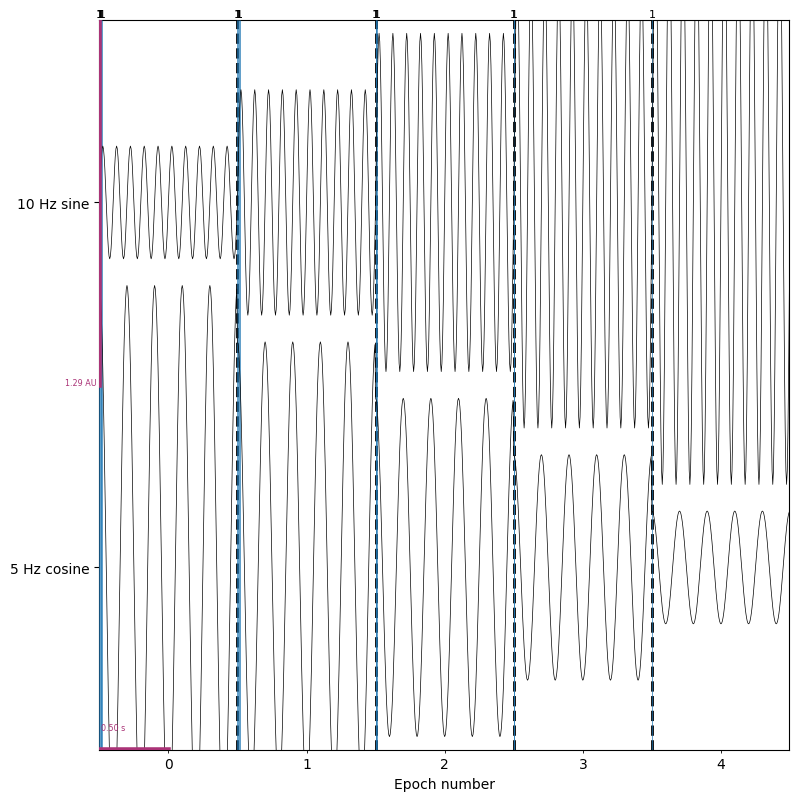

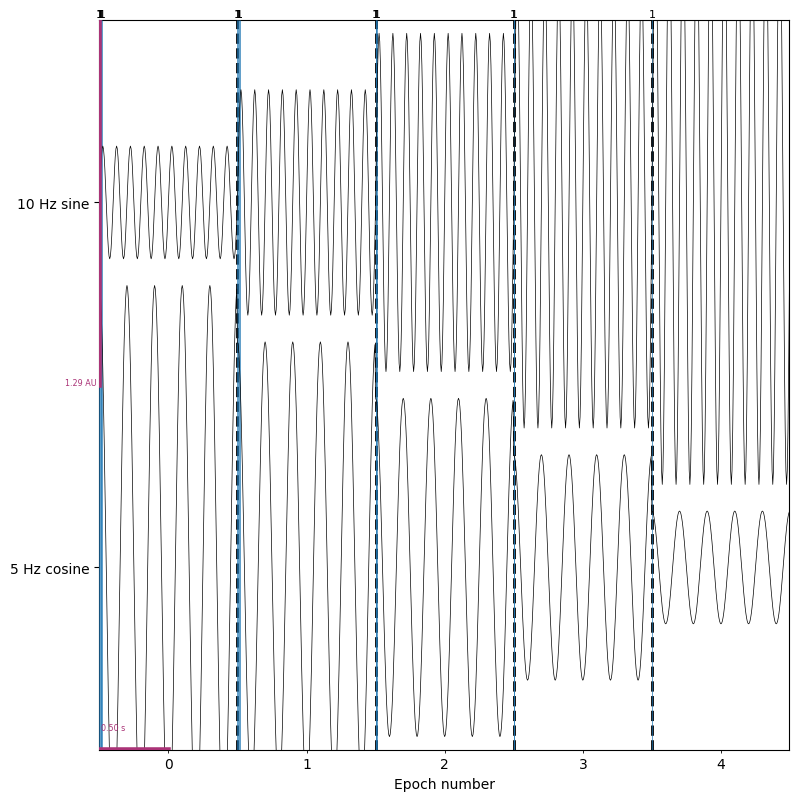

In [4]:
info = mne.create_info(
    ch_names=["10 Hz sine", "5 Hz cosine"], ch_types=["misc"] * 2, sfreq=sampling_freq
)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot(show_scrollbars=False, show_scalebars=False)
data = np.array(
    [
        [0.2 * sine, 1.0 * cosine],
        [0.4 * sine, 0.8 * cosine],
        [0.6 * sine, 0.6 * cosine],
        [0.8 * sine, 0.4 * cosine],
        [1.0 * sine, 0.2 * cosine],
    ]
)

simulated_epochs = mne.EpochsArray(data, info)
simulated_epochs.plot(picks="misc", show_scrollbars=False, events=True)